In [2]:
from __future__ import absolute_import, division, print_function

In [3]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [4]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [5]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [5]:
#import the book data
import string
from string import punctuation 
with open("/Users/VyUng/mystuff/sherlock.txt", 'r') as doc:
    t = doc.read()

In [6]:
#load tokenizer from nltk library
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [9]:
#Separate the text into a list of raw sentences
raw_sentences = tokenizer.tokenize(t)

In [79]:
print (raw_sentences[1000])

I asked.


In [11]:
#this function convert a sentence into a list of words without unnecessary split and hyphens
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [12]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
#Dimensionality of the parameter - word vector
#The higher dimension, the more accurate and more computationally expensive to train, 
num_features = 300 
#Minimum word count
min_word_count = 3 
# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count() 
# Context window length.
context_size = 7 
# Downsample setting for frequent words.
downsampling = 1e-3 
#random seed for replication
seed = 1 

In [49]:
#Build the model 
#This model uses the hierarchical softmax scheme - as illustrated in hs=1
sherlock_2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling,
    hs=1,
    negative=0
)

In [50]:
sherlock_2vec.build_vocab(sentences)

In [51]:
print("Word2Vec vocabulary length:", len(sherlock_2vec.wv.vocab))

Word2Vec vocabulary length: 3420


In [52]:
total_examples=sherlock_2vec.corpus_count

In [53]:
sherlock_2vec.train(sentences, total_examples=sherlock_2vec.corpus_count, epochs=sherlock_2vec.iter)

364666

In [54]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [55]:
sherlock_2vec.save(os.path.join("trained", "sherlock2vec.w2v"))

In [56]:
sherlock_2vec = w2v.Word2Vec.load(os.path.join("trained", "sherlock2vec.w2v"))

In [57]:
#Reduce dimension of word vectors to 2D
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [58]:
all_word_vectors_matrix = sherlock_2vec.wv.syn0

In [59]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [60]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[sherlock_2vec.wv.vocab[word].index])
            for word in sherlock_2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [61]:
points.head(10)

,word,x,y
0,Project,-67.078751,-3.406147
1,Gutenberg,-67.080513,-3.995462
2,s,4.326706,4.255617
3,The,-3.693015,-37.592628
4,Adventures,-43.997002,-13.030345
5,of,-11.445604,-28.536362
6,Sherlock,18.485592,39.131756
7,Holmes,18.249037,40.020493
8,by,-11.667984,-29.152195
9,Arthur,-41.459278,-15.542146


In [62]:
sns.set_context("poster")

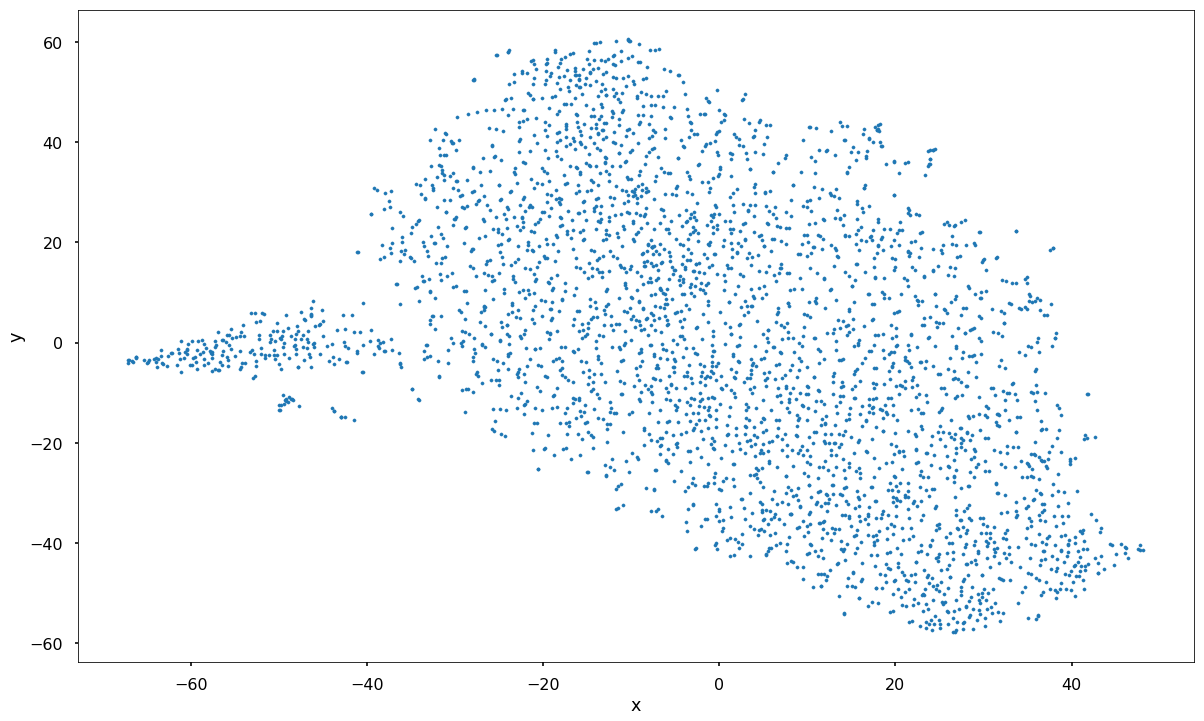

In [63]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [64]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

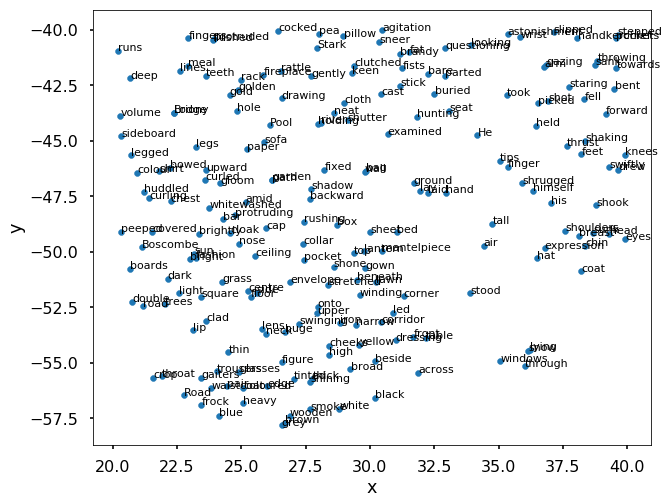

In [74]:
#Colors go together ("white","blue","black")
plot_region(x_bounds=(20, 40), y_bounds=(-60, -40))

In [66]:
#Find the most similar words to the target word 
#This result makes a lot of sense 
sherlock_2vec.most_similar("love")

[('wonder', 0.8808388710021973),
 ('deduced', 0.8728706240653992),
 ('value', 0.8727779388427734),
 ('invent', 0.8676943778991699),
 ('knows', 0.8561912178993225),
 ('dream', 0.8555319309234619),
 ('innocent', 0.8544013500213623),
 ('pity', 0.8529987335205078),
 ('maiden', 0.8466513156890869),
 ('correct', 0.8465006947517395)]

In [67]:
#Finding the degree of similarity between two words: 
sherlock_2vec.similarity("woman","man")

0.72820131007062994

In [68]:
#As with the famous example: woman + king - man = queen, 
#I did a similar thing here 
#But this is a very funny result: woman + marriage - man = seriously?
sherlock_2vec.most_similar(positive=['woman','marriage'],negative=['man'],topn=1)

[('seriously', 0.7484950423240662)]

In [81]:
#Probability of a text under the model
#Score can take a sequence of multiple sentences, and returns scores for each of them in order
#Here I have two sentences
#the scores are the log-likelihood of a sentence
#so negative values are to be expected
sherlock_2vec.score(['He killed the man'.split(),'I asked'.split()])

array([-78.61468506, -10.31398964], dtype=float32)